## Model Analysis and Explainability

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import pickle
import sys

import shap

from model_definitions import stanford_resnet
from data_processing import load_data, get_single_input

from collections import Counter

In [2]:
# Load in final model1
model = tf.keras.models.load_model('./model1/final_model')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 187, 32)      192         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 187, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 187, 32)      0           ['batch_normalization_9[0][

 batch_normalization_16 (BatchN  (None, 187, 32)     128         ['conv1d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 187, 32)      0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)           (None, 187, 32)      0           ['activation_16[0][0]']          
                                                                                                  
 conv1d_17 (Conv1D)             (None, 187, 32)      5152        ['dropout_13[0][0]']             
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 187, 32)     0           ['add_6[0][0]']                  
          

In [3]:
# Load in the training and test data
train_data, train_labels = load_data("./archive/mitbih_train.csv")
train_data = np.expand_dims(train_data, axis=2)

test_data, test_labels = load_data("./archive/mitbih_test.csv")
test_data = np.expand_dims(test_data, axis=2)

predictions = model.predict(test_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

685/685 [==============================] - 7s 8ms/step


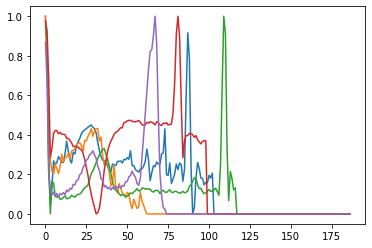

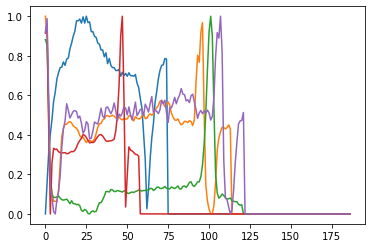

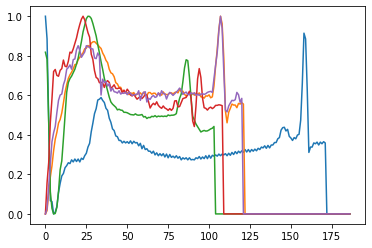

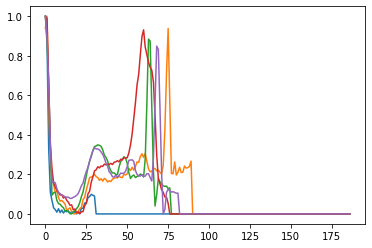

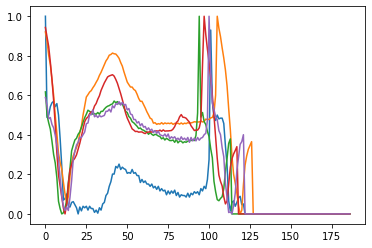

In [4]:
# Take a quick look at some of the samples
def plot_class(test_data, test_labels, obj_class, number):
    indices = np.where(test_labels==obj_class)
    plt.figure()
    samples = np.random.choice(indices[0], number, replace=False)
    for i in samples:
        plt.plot(test_data[i,:,0])
    plt.show()
    return

plot_class(test_data,test_labels,0,5)
plot_class(test_data,test_labels,1,5)
plot_class(test_data,test_labels,2,5)
plot_class(test_data,test_labels,3,5)
plot_class(test_data,test_labels,4,5)


Using SHAP, see if there are any particular patterns that highlight what the model is using to classify inputs.

In [5]:
# Using SHAP, see if there are any particular patterns that can highlight why the model predicts
# an input a certain way

explainer = shap.GradientExplainer(model, train_data)

Just from this, it is pretty difficult to see what exactly is influencing the model predictions.
Replot the results to better see the influences based on the input image.

1/1 [==============================] - 0s 21ms/step
Looking at SHAP results for : Fusion of Ventricular and Normal Beat


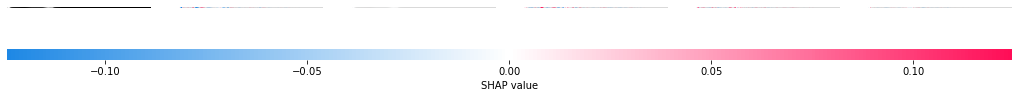

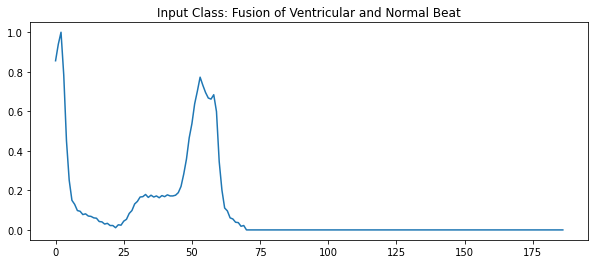

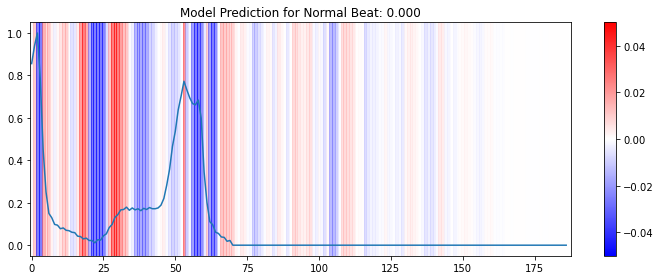

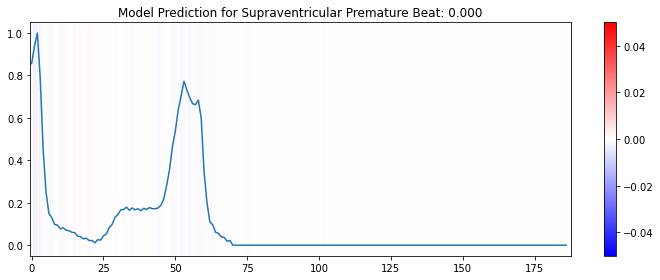

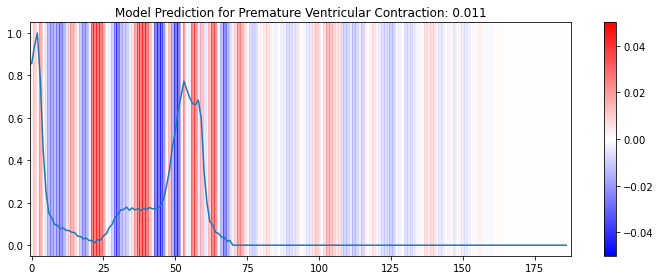

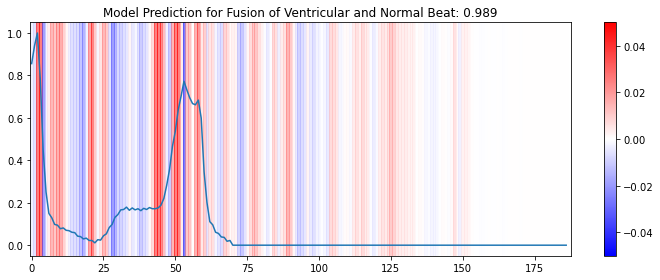

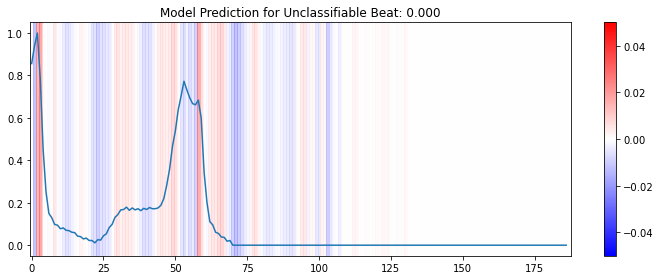

In [34]:
# Randomly select one input from a specific class
class_names = [
    'Normal Beat', 
    'Supraventricular Premature Beat',
    'Premature Ventricular Contraction',
    'Fusion of Ventricular and Normal Beat',
    'Unclassifiable Beat']
object_class = 3
test_input = get_single_input(test_data, test_labels, object_class)

# test_input is in shape (187,1), needs to be (1,187,1) to properly work with SHAP
test_input = np.expand_dims(test_input, axis=0)
test_predict = model.predict(test_input)

# Get the performance for a single object
print('Looking at SHAP results for : {}'.format(class_names[object_class]))
shap_values = explainer.shap_values(test_input)
shap.image_plot(shap_values, test_input)

# Plot the original input
plt.figure(figsize=(10,4))
plt.plot(test_input[0,:,0])
plt.title('Input Class: {}'.format(class_names[object_class]))
plt.show()

# Highlight SHAP values over the input
for i in range(5):

    plt.figure(figsize=(10,4))
    plt.plot(test_input[0,:,0])

    # Add in the vertical data
    cmap = matplotlib.cm.get_cmap('bwr')
    norm = matplotlib.colors.Normalize(vmin=-0.05, vmax=0.05)
    x_range = np.arange(-0.5, 187.5, 1)
    for j in range(len(shap_values[i][0,:,0])):
        c_val = shap_values[i][0,j,0]
        plt.axvspan(x_range[j], x_range[j+1], color=cmap(norm(c_val)), alpha=0.5)

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)

    title_string = 'Model Prediction for {}: {:.3f}'
    plt.title(title_string.format(class_names[i], test_predict[0][i]))
    plt.xlim([-0.5,187.5])
    plt.tight_layout()
    plt.show()
    

Using this information, it might be possible to get an understanding of what specific features are being used by the Machine Learning Model to 

Given the setup of the dataset for this problem, the model will only perform classifications on segmented pieces of the ECG heartbeat readings. Assuming that it is possible to identify and separate these waveforms before being turned into model inputs, there should be little problem with implementing the model like this.

However, if this model was given a real time ECG reading, how well would it perform? 

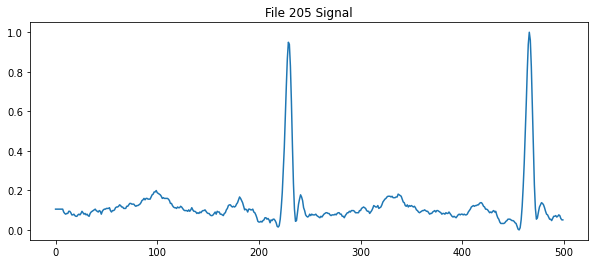

In [8]:
# Load in 205 Data
import wfdb
record = wfdb.rdsamp('./archive/205', sampto=500)

signal = record[0][:,0]
signal_norm = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

plt.figure(figsize=(10,4))
plt.plot(signal_norm)
plt.title('File 205 Signal')
plt.show()

In [9]:
# Run Machine Learning Model against real time data.
real_time_data = np.zeros((len(signal_norm)-187, 187))

for i in range(len(signal_norm)-187):
    real_time_data[i,:] = signal_norm[i:i+187]
real_time_data = np.expand_dims(real_time_data, axis=2)
    
real_time_predictions = model.predict(real_time_data)


10/10 [==============================] - 0s 9ms/step


In [31]:
# Create an animation that shows the model classifications over time. 
# Currently saving then deleting images, could make better solution using Matplotlib Animate
# modules.
if not os.path.exists('./images/'):
    os.makedirs('./images/')

x_data = np.arange(187,len(signal_norm))
for i in range(len(signal_norm)-187):
    print('Working on image {}/{}'.format(i+1, len(signal_norm)-187), end='\r')
    fig, ax = plt.subplots(2, figsize=(10,8))
    fig.suptitle('Model Prediction Over Time')
    ax[0].plot(signal_norm)
    ax[0].axvspan(i,i+187, color='black', alpha=0.2)
    ax[0].set_xlim([0,len(signal_norm)])
    
    for j in range(5):
        ax[1].plot(x_data[:i], real_time_predictions[:i,j])
    
    ax[1].legend(labels=class_names, loc='lower left')
    ax[1].set_xlim([0, len(signal_norm)])
    
    fig.savefig('./images/{}.png'.format(i))
    plt.close()
    


In [32]:
import imageio

images = []
for i in range(len(signal_norm)-187):
    file = '{}.png'.format(i)
    file_path = os.path.join('./images', file)
    images.append(imageio.imread(file_path))
    
imageio.mimsave('./images/movie3.gif', images, fps=24)



![SegmentLocal](./images/movie3.gif "segment")


As expected, the predictions for the model do not perform very well against a real time example of an ECG reading.
